In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `C:\Users\jonbs\Documents\JonathanStuff\CMU_Stuff\year2\OCRL\Quadrotor_MPC_with_Kalman_Filter\Project.toml`


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

TODO: some more 'splainin here

The objective / cost function for our optimization problem is of the following form:

$$\ell(x_{1:N}, u_{1:N-1}) = J_N(x_N) + \sum_{i=1}^{N-1} J(x_k,u_k) $$

Where the *stage cost* $J(x_k,u_k)$ is defined as:

$$J(x,u) = \frac{1}{2}(x - x_{ref})^TQ(x - x_{ref}) + \frac{1}{2}(u -u_{ref})^TR(u-u_{ref})$$

And the *terminal cost* is

$$J_N(x) = \frac{1}{2}(x - x_{ref})^TQ_f(x - x_{ref})$$

In [342]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")
# TODO: something to verify dynamics funcs work
const nx = 13
const nu = 4
const dt = 0.025
const T = 5.0
const N = Int(T / dt)

model = Quadrotor()

# x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
# x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
Q[1:3,1:3] .= 100.0*I(3)
Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);

# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LQR converged in 158 iterations


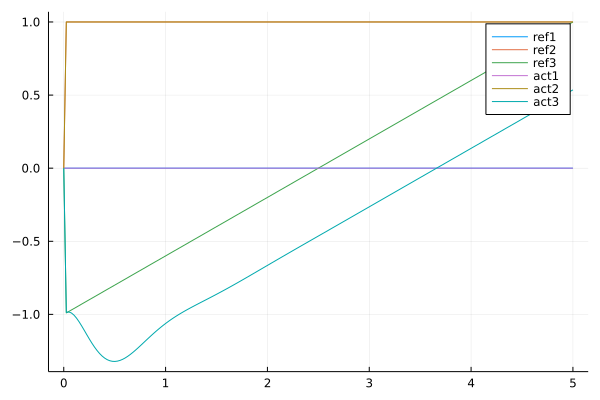

In [346]:
include("quadrotor.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

X_line = line_reference(N, dt)
X_LQR[1] = copy(X_line[1])

vals_ref = zeros(N,3)
vals_act = zeros(N,3)

for k = 1:N-1
    
#     println(k, "\t", X_LQR[k])
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
#     println("\tdX: ", dX)

    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
#     println("\tU adj:  ", (K_LQR * dX)[:,1])
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, label=["ref1" "ref2" "ref3"])
plot!(tref, vals_act, label=["act1" "act2" "act3"])

In [69]:
# Reference Trajectory

# TODO: make a function that auto-generates trajetories with trapezoidal velocity profiles (or something better)

# Xref = [ [i/100.0 i/100.0 i/100.0 1 zeros(9)'] for i = 1:N]; # Note: the 1 is to make quats unit norm
# Xref = zeros(N,nx);

# Uref = [copy(uhover) for i = 1:N-1];
# tref = LinRange(0.0, T, N);

# mpc = build_MPC_QP(Xref, Uref, tref, A, B, Q, R, Qf) 

In [31]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8704))

In [319]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)

# visualize!(vis, model, dt*(N-1), line_ref)
visualize!(vis, model, dt*(N-1), X_LQR)

In [ ]:
include("MPC.jl")

Q = I(nx)
R = I(nu)
Qf = I(nx)